In [566]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

# sklearn
# fuzzywuzzy
# scipy
# arules

## Part I. Data Viewing


In [567]:
data_path = 'survey_results.csv'
data_raw_df= pd.read_csv(data_path)
data_raw_df.head(1)

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [568]:
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [569]:
# data_raw_df.describe()

In [570]:
# null = pd.DataFrame({'Null Values':data_raw_df.isnull().sum(),'Percentage Null Values':data_raw_df.isnull().sum()*100/len(data_raw_df)})
# null

In [571]:
# for column_name in data_raw_df.columns:
#     print(column_name)
#     print(data_raw_df[column_name].unique())
#     print("")

## Part II. Data Cleaning


In [572]:
# Data Cleaning
# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customised_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "personally_design_interest",
                            "How much are you willing to pay for the personalised design? ": "personally_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head(1)



,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customised_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,personally_design_interest,personally_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [573]:
data_mod_df['personally_design_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['personally_design_spend'] == '100-500' else row['personally_design_spend'], axis=1)
data_mod_df['customisation_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['customisation_spend'] == '100-500' else row['customisation_spend'], axis=1)

In [574]:
# data_mod_df['exterior_components_customisation'].fillna('None', inplace=True)

In [575]:
data_mod_df=data_mod_df.dropna(subset=['exterior_components_customisation'])
data_mod_df=data_mod_df.dropna(subset=['purchase_factors'])

In [576]:
data_mod_2 = data_mod_df.copy()

In [577]:
data_mod_df['purchase_factors'] = data_mod_df['purchase_factors'].str.split(';')
data_mod_df['exterior_components_customisation'] = data_mod_df['exterior_components_customisation'].str.split(';')
data_mod_df['interior_components_customisation'] = data_mod_df['interior_components_customisation'].str.split(';')
data_mod_df.head()

,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customised_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,personally_design_interest,personally_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],under 500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Likely,"[Wheels, Grilles, Headlights, Side mirrors]",[Centre compartment],under 500,Only with professional help,under 500,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Aesthetics, Functionality, Customisable options]",Very likely,"[Wheels, Grilles, Headlights, Side mirrors]","[Steering wheel, Dashboard]",500-1000,Yes,500-1000,"Yes, I can design on my own",NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Side mirrors, Bu...","[Steering wheel, Centre compartment, Door hand...",under 500,Yes,under 500,"No, I would need a designer to model my sketch",NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Bumpers]","[Steering wheel, Centre compartment]",over 1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch",Sg flag/ colour related car paint


In [578]:
data_mod_df.reset_index(drop=True, inplace=True)

## Part III. Data Exploration


In [579]:
purchase_factor_counts = data_mod_df['purchase_factors'].explode().value_counts()
interior_components_counts = data_mod_df['interior_components_customisation'].explode().value_counts()
exterior_components_counts = data_mod_df['exterior_components_customisation'].explode().value_counts()

In [580]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

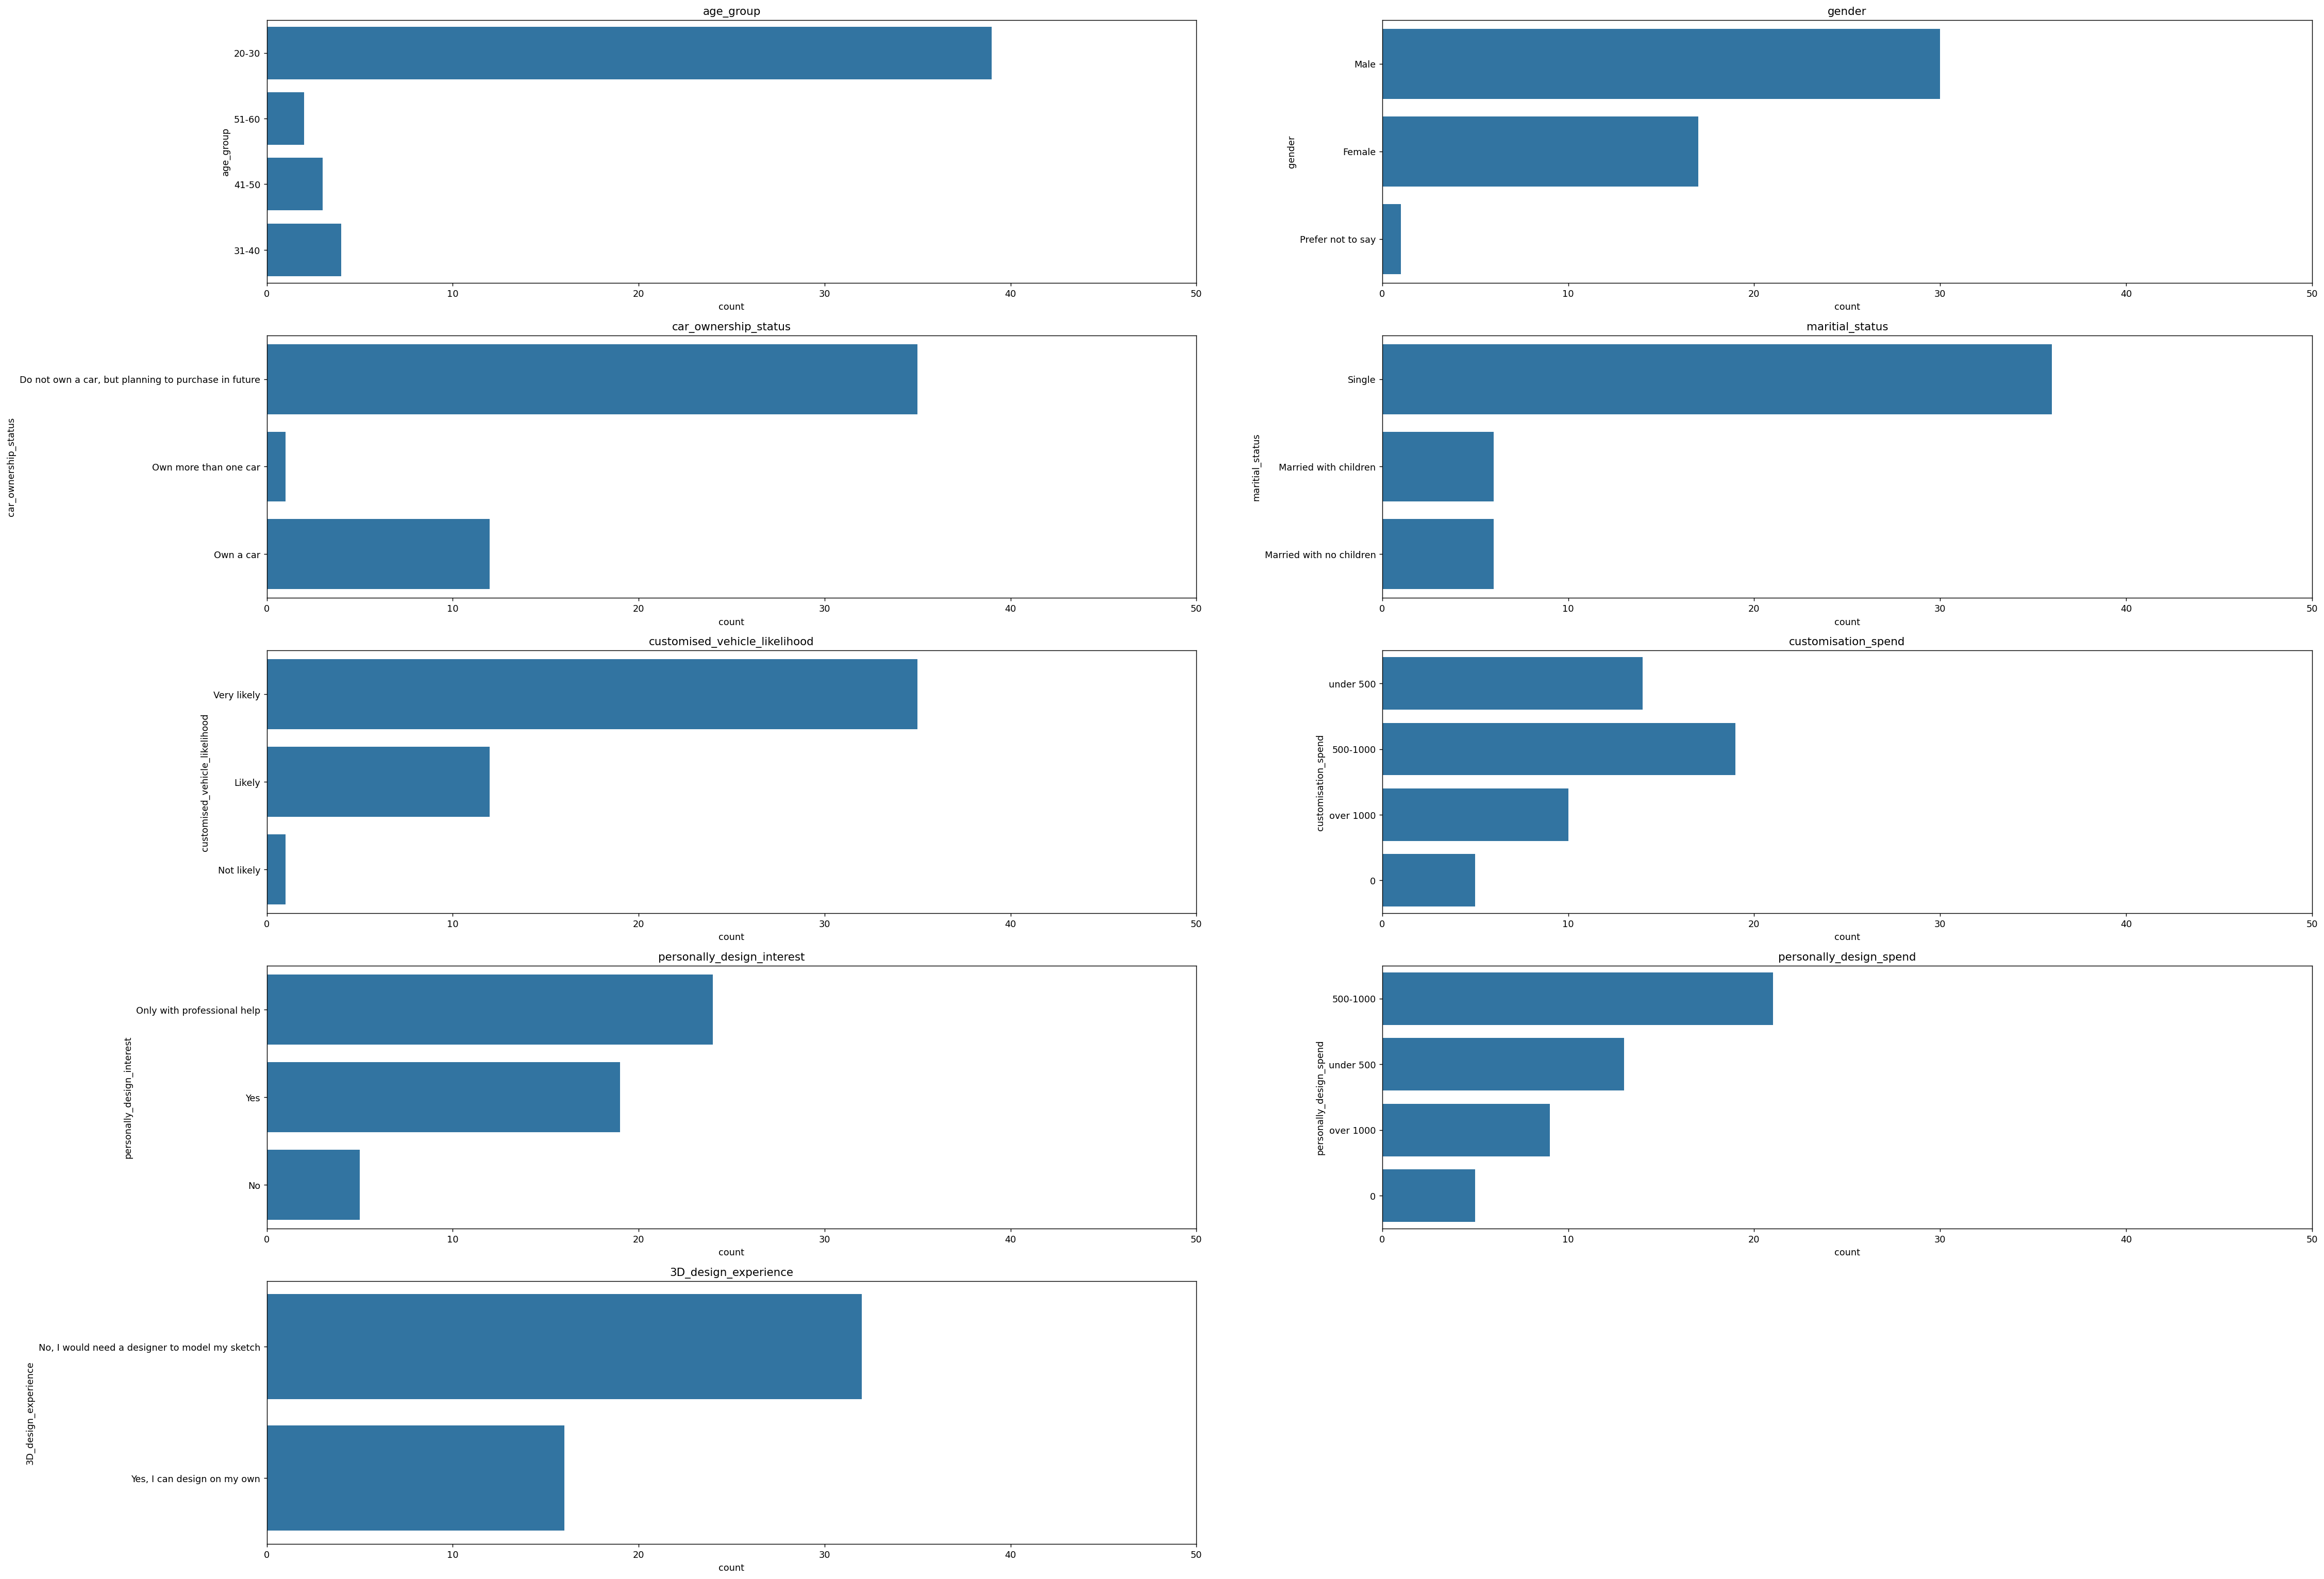

In [581]:
column_names = ['age_group', 
                'gender', 
                'car_ownership_status', 
                'maritial_status', 
                'customised_vehicle_likelihood', 
                'customisation_spend', 
                'personally_design_interest', 
                'personally_design_spend', 
                '3D_design_experience'
                ]
fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data=data_mod_df, y=col, orient='h')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

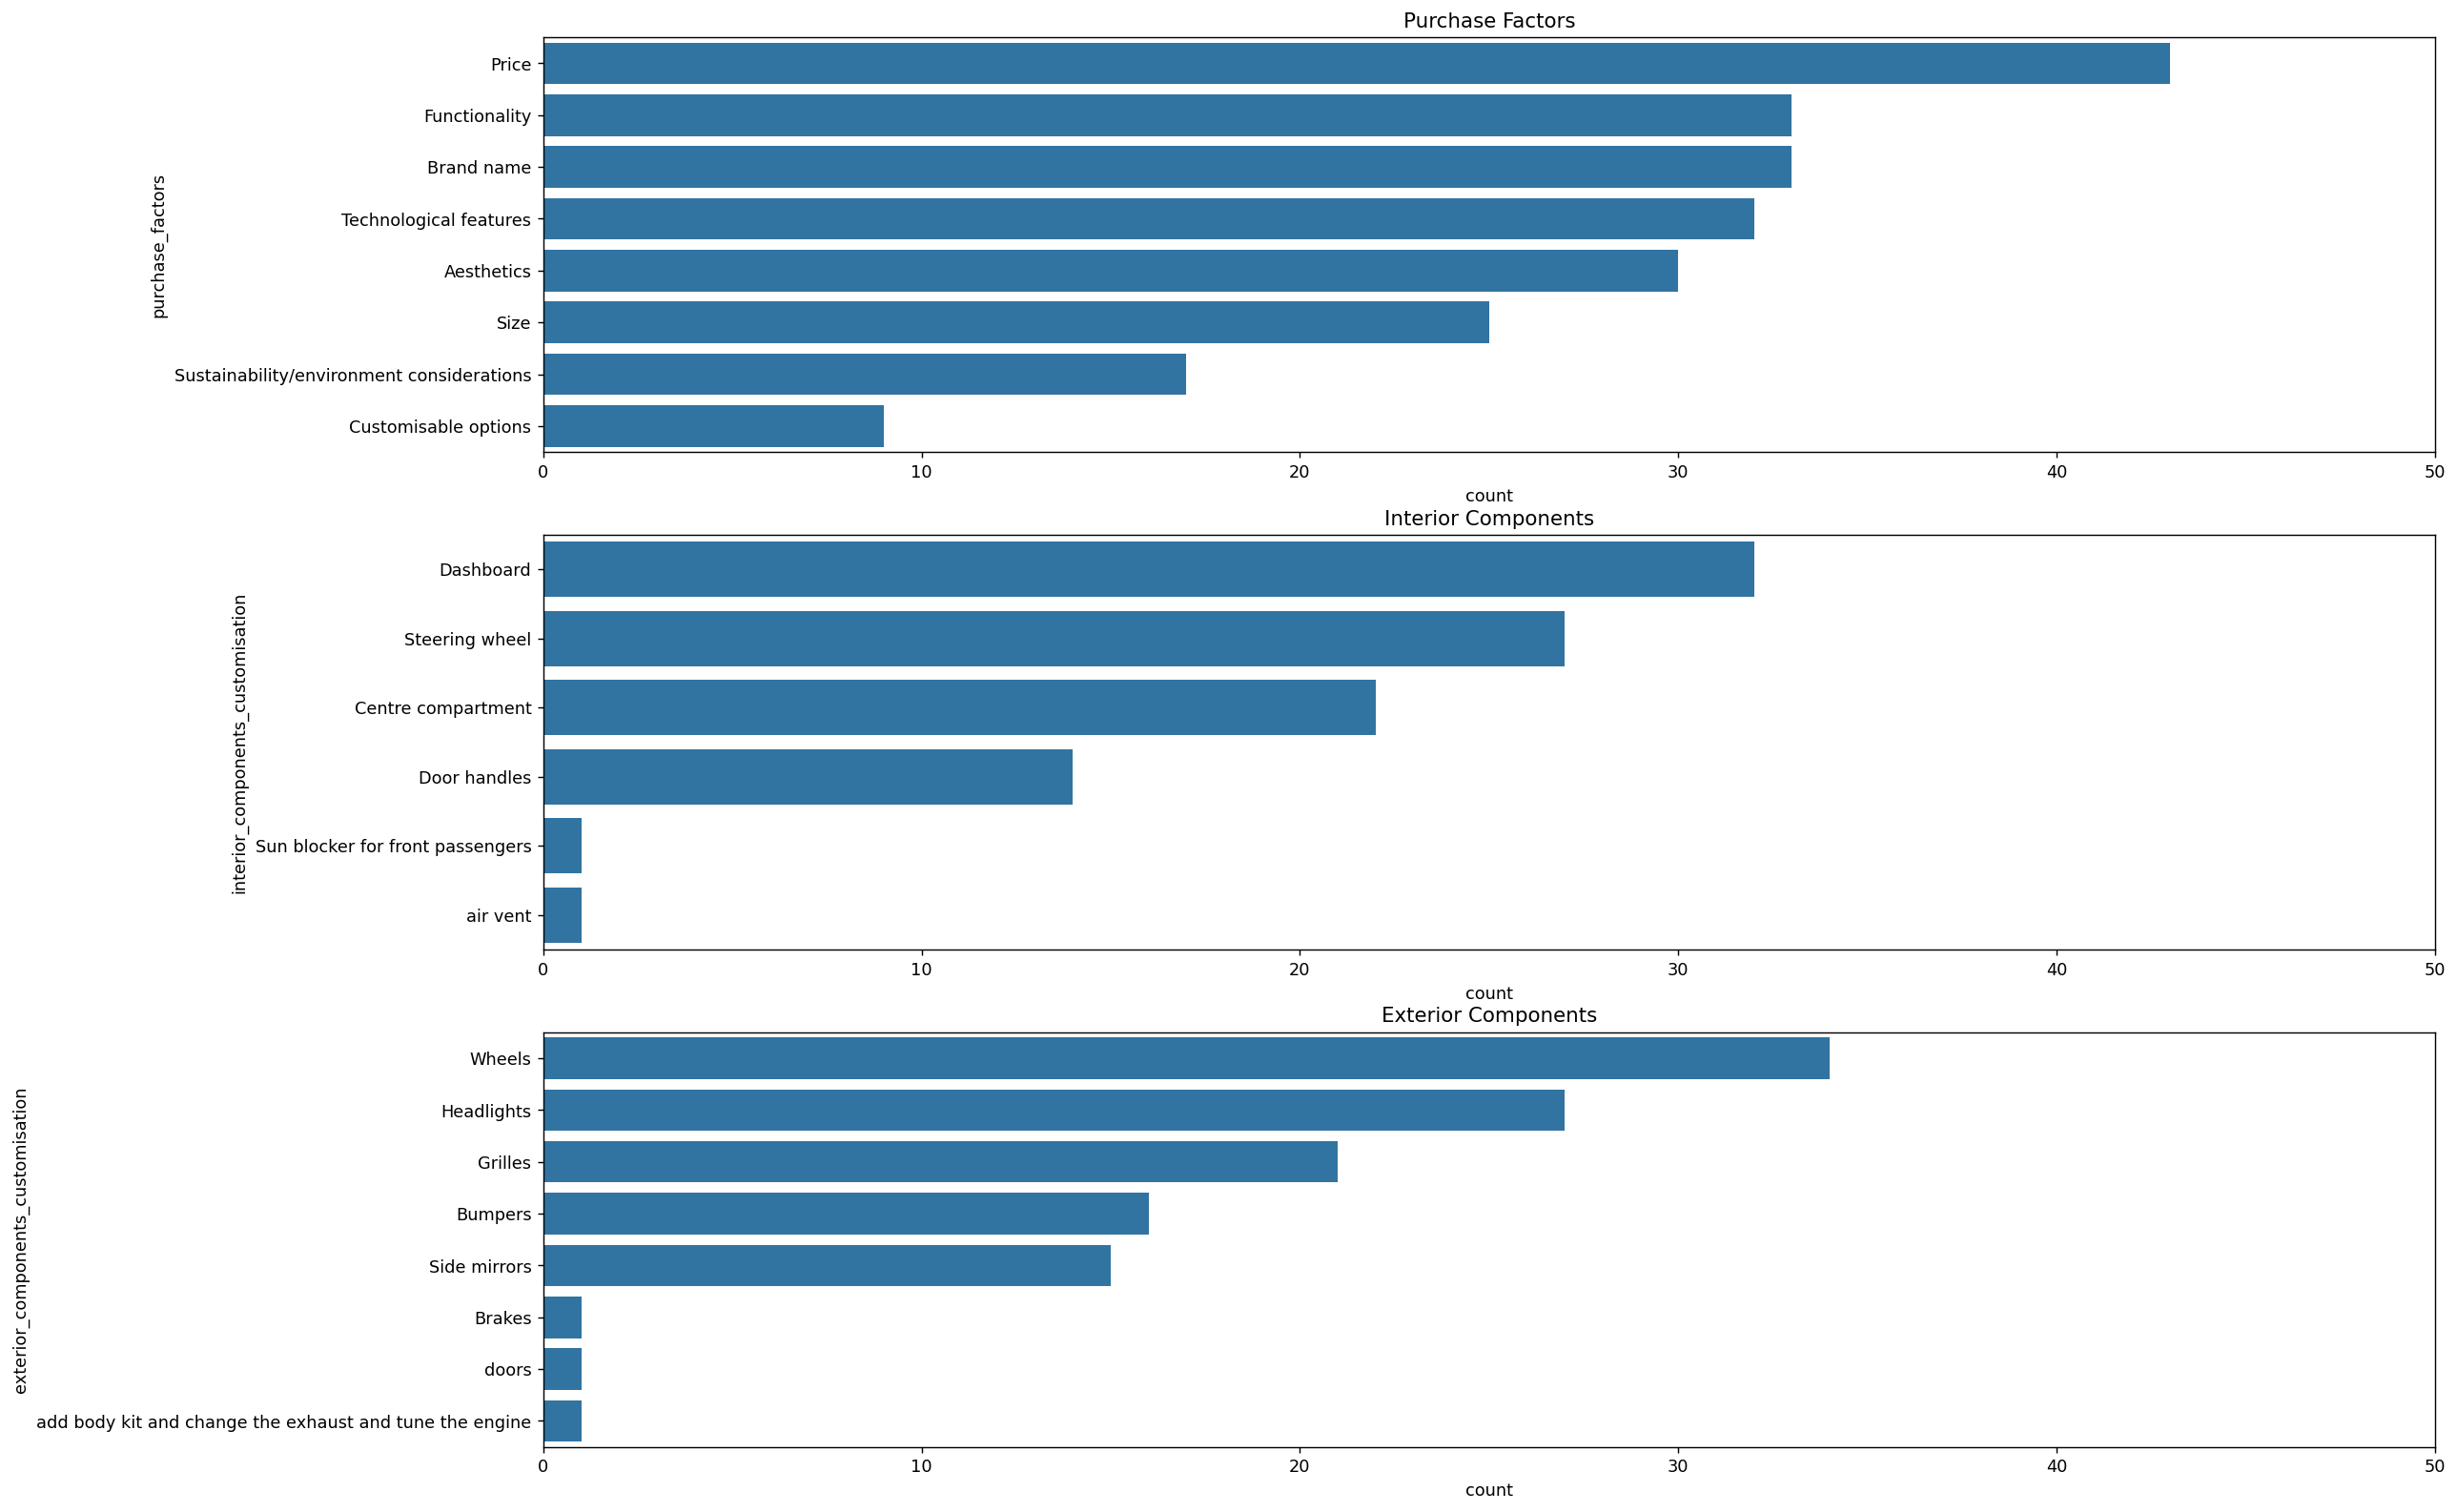

In [582]:
fig, ax = plt.subplots(dpi = 128, figsize=(20, 15))
plt.axis('off')
plt.subplot(3, 1, 1)
plt.title('Purchase Factors')
plt.xlim(0,50)
sns.barplot(data=purchase_factor_counts, orient='h')
plt.subplot(3, 1, 2)
plt.title('Interior Components')
plt.xlim(0,50)
sns.barplot(data=interior_components_counts, orient='h')
plt.subplot(3, 1, 3)
plt.title('Exterior Components')
plt.xlim(0,50)
sns.barplot(data=exterior_components_counts, orient='h')
plt.show()

In [583]:
purchase_factor_counts.index

Index(['Price', 'Functionality', 'Brand name', 'Technological features',
       'Aesthetics', 'Size', 'Sustainability/environment considerations',
       'Customisable options'],
      dtype='object', name='purchase_factors')

In [584]:
exterior_components_counts.index

Index(['Wheels', 'Headlights', 'Grilles', 'Bumpers', 'Side mirrors', 'Brakes',
       'doors', 'add body kit and change the exhaust and tune the engine'],
      dtype='object', name='exterior_components_customisation')

In [585]:
interior_components_counts.index

Index(['Dashboard', 'Steering wheel', 'Centre compartment', 'Door handles',
       'Sun blocker for front passengers', 'air vent'],
      dtype='object', name='interior_components_customisation')

## Encoding Data


In [586]:
from sklearn.preprocessing import LabelEncoder

In [587]:
def encode_data_by_count(column_name, data_frame):
  print("_"*120)
  label_encoder = LabelEncoder()
  encoded_column_name = column_name+"_encoded"
  data_frame[encoded_column_name] = label_encoder.fit_transform(data_frame[column_name])
  legend = data_frame[[column_name, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
  data_frame.drop(column_name, axis=1, inplace=True)

def encode_by_label(df, unique_values, col):
  print("_"*120)
  encoded_column_name = col+"_encoded"
  for i, val in enumerate(unique_values):
    if val not in df[col].unique():
      print(f"'{val}' not in {col}")
      return
  label_mapping = {val: i for i, val in enumerate(unique_values)}
  df[encoded_column_name] = df[col].map(label_mapping)
  legend = df[[col, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
  df.drop(col, axis=1, inplace=True)

In [588]:
encode_by_label(data_mod_df, ['20-30', '31-40', '41-50', '51-60'],'age_group')
encode_by_label(data_mod_df, ['Do not own a car, but planning to purchase in future', 'Own a car', 'Own more than one car'], 'car_ownership_status')
encode_by_label(data_mod_df, ['Not likely', 'Likely', 'Very likely'], 'customised_vehicle_likelihood')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'customisation_spend')
encode_by_label(data_mod_df, ['No', 'Only with professional help', 'Yes'], 'personally_design_interest')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'personally_design_spend')
encode_by_label(data_mod_df, ['No, I would need a designer to model my sketch', 'Yes, I can design on my own'], '3D_design_experience')

________________________________________________________________________________________________________________________
  age_group  age_group_encoded
0     20-30                  0
1     51-60                  3
2     41-50                  2
3     31-40                  1
________________________________________________________________________________________________________________________
                                car_ownership_status  \
0  Do not own a car, but planning to purchase in ...   
1                              Own more than one car   
2                                          Own a car   

   car_ownership_status_encoded  
0                             0  
1                             2  
2                             1  
________________________________________________________________________________________________________________________
  customised_vehicle_likelihood  customised_vehicle_likelihood_encoded
0                   Very likely                   

In [589]:
encode_data_by_count('gender', data_mod_df)
encode_data_by_count('maritial_status', data_mod_df)

________________________________________________________________________________________________________________________
              gender  gender_encoded
0               Male               1
1             Female               0
2  Prefer not to say               2
________________________________________________________________________________________________________________________
            maritial_status  maritial_status_encoded
0                    Single                        2
1     Married with children                        0
2  Married with no children                        1


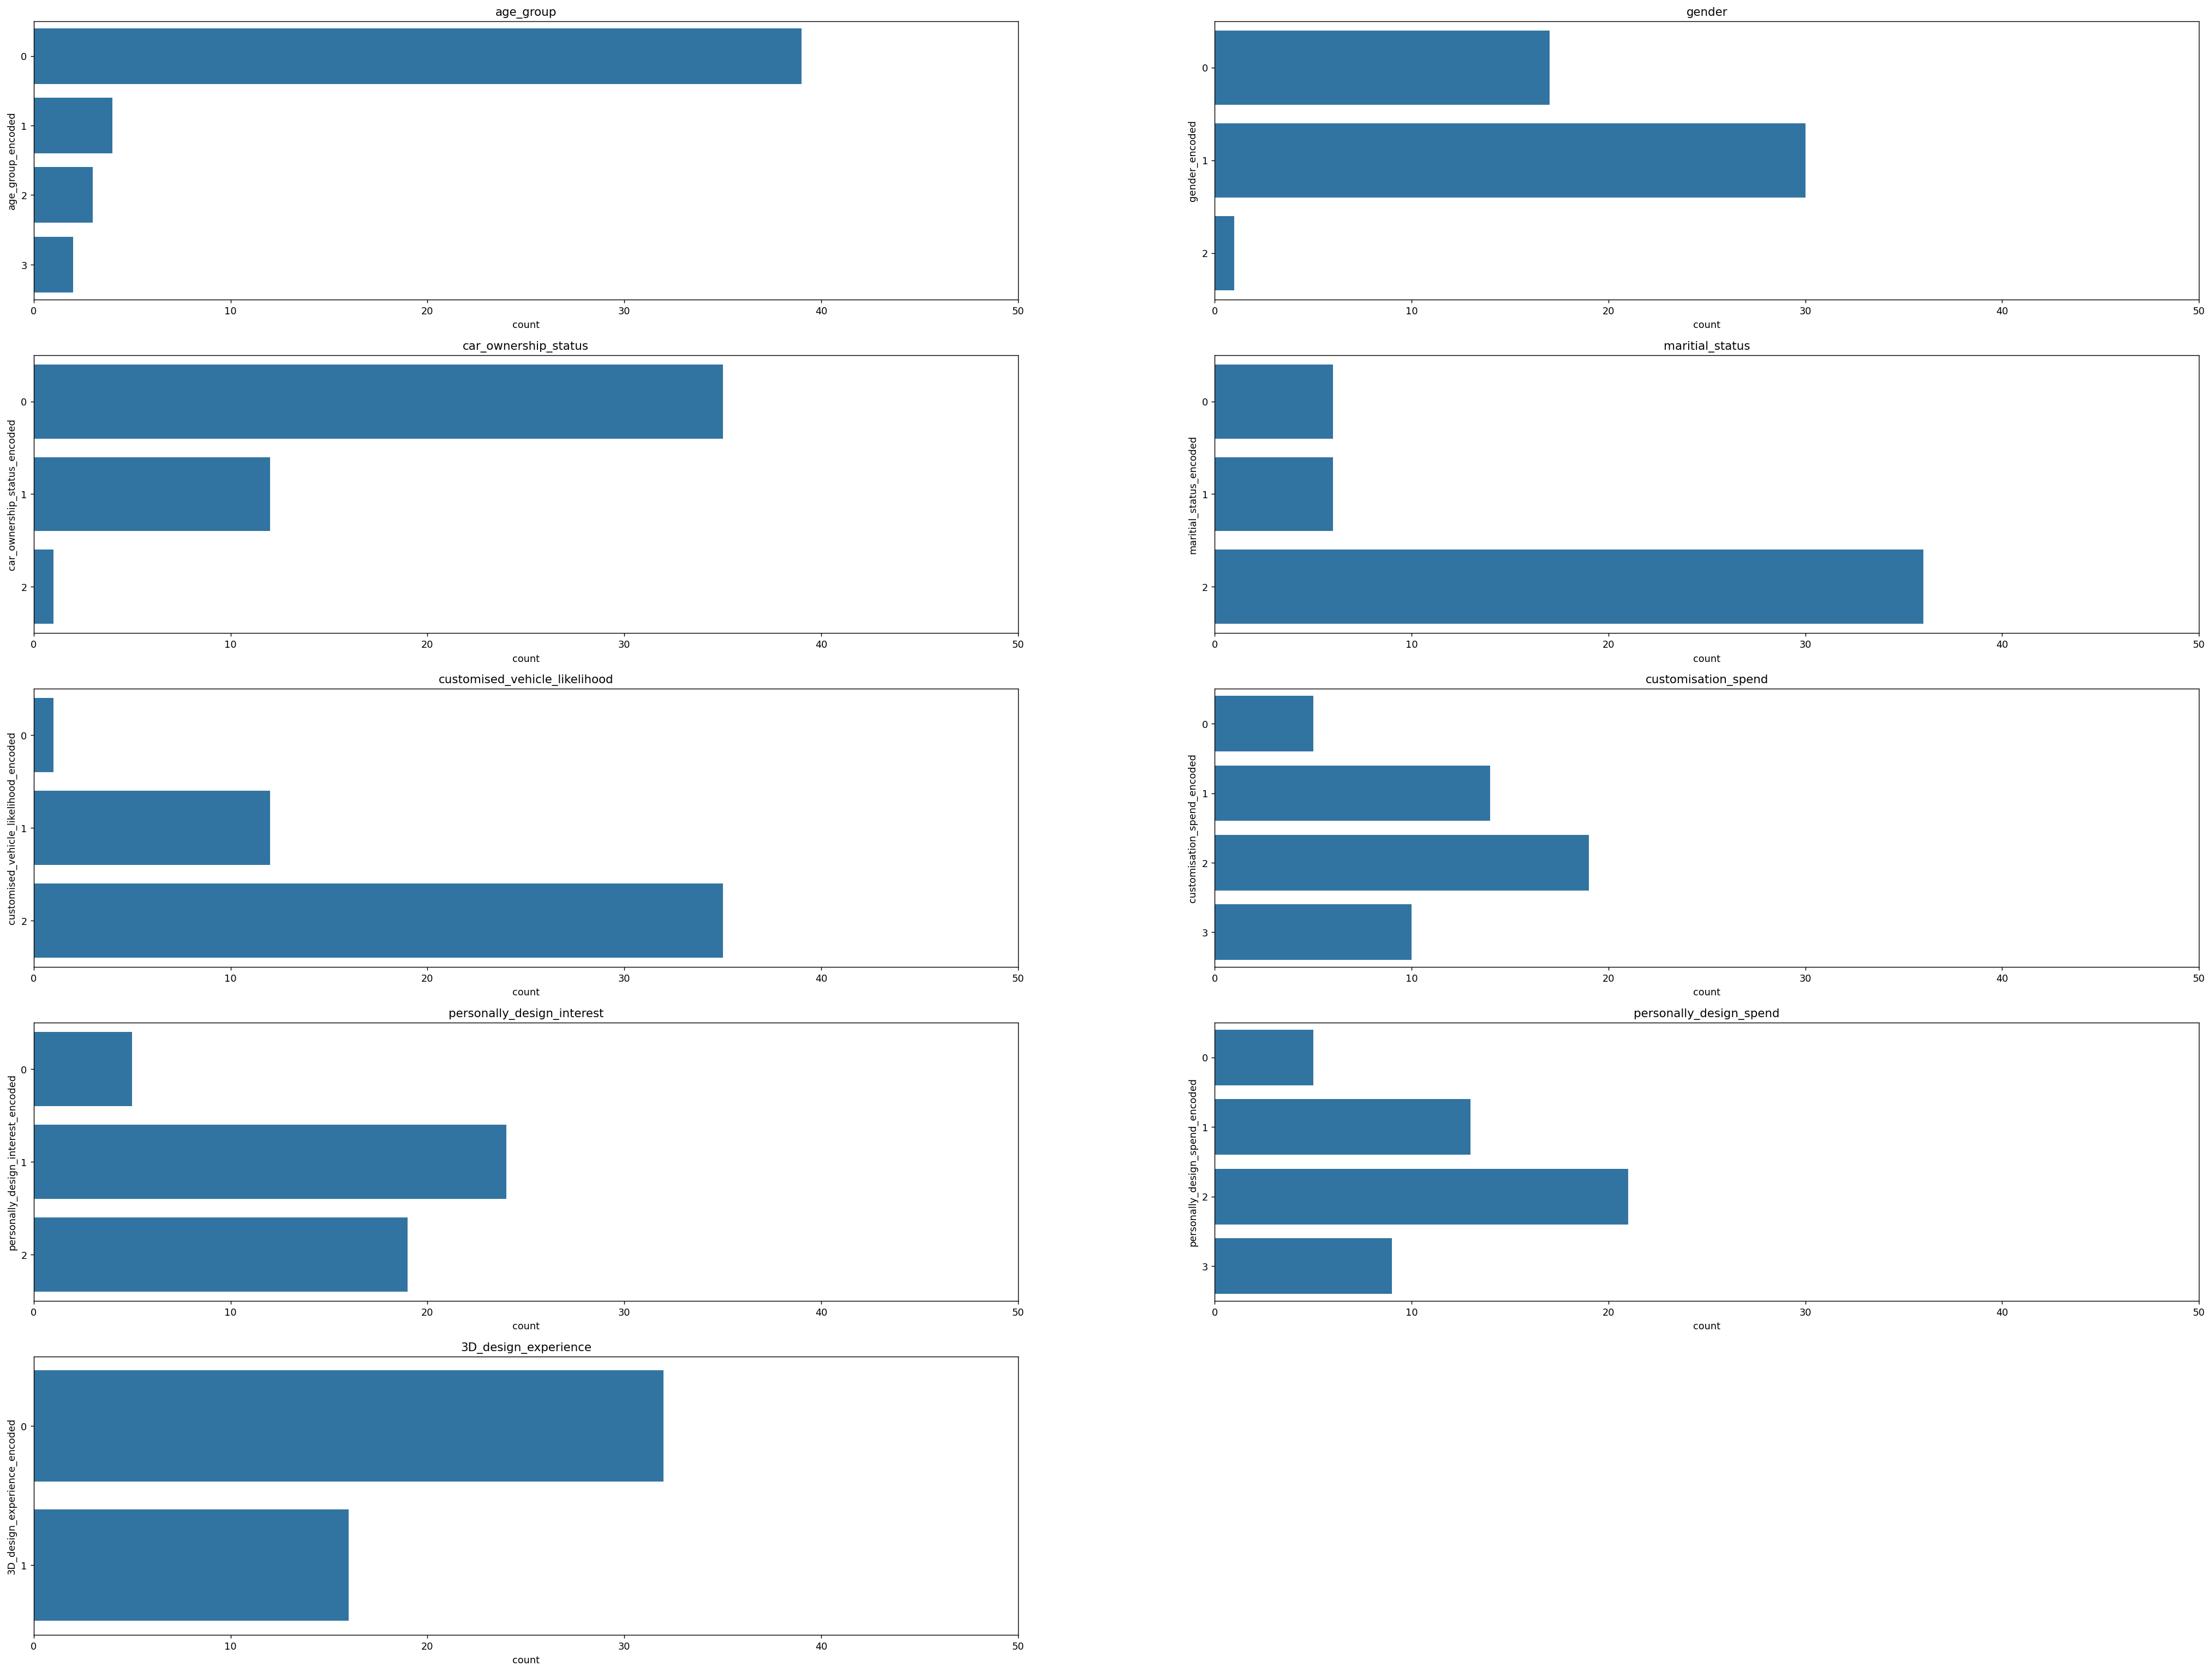

In [590]:
fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data=data_mod_df, y=col+'_encoded', orient='h')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

In [591]:
data_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   purchase_factors                       48 non-null     object
 1   exterior_components_customisation      48 non-null     object
 2   interior_components_customisation      48 non-null     object
 3   design_ideas                           17 non-null     object
 4   age_group_encoded                      48 non-null     int64 
 5   car_ownership_status_encoded           48 non-null     int64 
 6   customised_vehicle_likelihood_encoded  48 non-null     int64 
 7   customisation_spend_encoded            48 non-null     int64 
 8   personally_design_interest_encoded     48 non-null     int64 
 9   personally_design_spend_encoded        48 non-null     int64 
 10  3D_design_experience_encoded           48 non-null     int64 
 11  gender_encoded       

## Part IV. Modelling


In [592]:
data_mod_df['customised_vehicle_likelihood_encoded'].unique()

array([2, 1, 0])

In [593]:
def find_classes(df):
    res_dict = {}
    for col in df.columns:
      res_dict[col+'_classes'] = [df[str(col)].unique()]
    res_df = pd.DataFrame(data=res_dict)
    display(res_df)

In [594]:
from sklearn.model_selection import train_test_split

predict likelihood of making customisation.
include: purchase_factors, age_group, car_ownership, 3D design experience, customised_vehicle_likelihood
exclude: exterior_components_customisation, interior_components_customisation,design_ideas, customisation_spend_encoded, customisation_spend, personally_design_interest_encoded, personally_design_spend_encoded


In [595]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score,confusion_matrix,classification_report

In [596]:
def model_evaluation(model, X_train, X_test, y_train, y_test, print_results=True):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  if print_results:
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Precision Score: \n{precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
  # tp, fn, fp, tn = confusion_matrix(y_test,y_pred).reshape(-1)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  model_dict={'Model': [model.__class__.__name__], 'Accuracy': [round(accuracy,3)], 'F1_Score': [round(f1,3)], 'Precision': [round(precision,3)], 'Recall': [round(recall,3)]}
  try:
    model_df = pd.DataFrame(data=model_dict)
  except:
    print("Error creating model_df")
    print(model_dict)
    return
  return model, model_df

In [597]:
import random
def random_data_gen(df, y ,n=1000):
  random_dict = {}
  for col in df.columns:
    if col == y:
      continue
    random_dict[col] = []
    for i in range(1000):
      random_dict[col].append(random.choice(df[col].unique()))
  random_data = pd.DataFrame(data=random_dict)
  return random_data

In [598]:
def test_feature_omission(df, observed ,model, n):
  res_knn = pd.DataFrame(columns=['Ommited Feature','Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
  for col in df.columns:
    if col == observed:
      continue
    y = df[observed]
    X = df.drop([observed, col], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    _,model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
    model_df['Ommited Feature'] = col
    res_knn = pd.concat([res_knn, model_df], ignore_index=True)
  res_knn = res_knn.sort_values(by='Accuracy', ascending=True)
  res_knn = res_knn.reset_index(drop=True)
  display(res_knn.head(n))

In [599]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), KNeighborsClassifier(), GaussianNB()]

In [600]:
data_1 = data_mod_df.copy()
dropped_columns = [ 'exterior_components_customisation', 
                    'interior_components_customisation', 
                    'design_ideas', 
                    'customisation_spend_encoded', 
                    'personally_design_interest_encoded', 
                    'personally_design_spend_encoded']
data_1.drop(dropped_columns, axis=1, inplace=True)
data_1.dropna()
purchase_factors_dummies = pd.get_dummies(data=data_1['purchase_factors'].explode(), dtype=int, prefix='purchase_factors')
merged_df = purchase_factors_dummies.groupby(purchase_factors_dummies.index).sum()
data_1 = pd.concat([data_1, merged_df], axis=1)
data_1.drop('purchase_factors', axis=1, inplace=True)
data_1 = data_1[data_1['gender_encoded'] != 2].copy()
data_1.reset_index(drop=True, inplace=True)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 14 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   age_group_encoded                                           47 non-null     int64
 1   car_ownership_status_encoded                                47 non-null     int64
 2   customised_vehicle_likelihood_encoded                       47 non-null     int64
 3   3D_design_experience_encoded                                47 non-null     int64
 4   gender_encoded                                              47 non-null     int64
 5   maritial_status_encoded                                     47 non-null     int64
 6   purchase_factors_Aesthetics                                 47 non-null     int64
 7   purchase_factors_Brand name                                 47 non-null     int64
 8   purchase_factors_Custo

In [601]:
data = data_1.copy()
y = data['customised_vehicle_likelihood_encoded']
X = data.drop('customised_vehicle_likelihood_encoded', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
customised_vehicle_likelihood_model = {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/797476317.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined a

,Model,Accuracy,F1_Score,Precision,Recall
0,LogisticRegression,0.800,0.711,0.640,0.800
1,DecisionTreeClassifier,0.733,0.704,0.677,0.733
2,RandomForestClassifier,0.733,0.677,0.629,0.733
3,ExtraTreesClassifier,0.733,0.704,0.677,0.733
4,GaussianNB,0.733,0.677,0.629,0.733
5,KNeighborsClassifier,0.667,0.667,0.667,0.667


In [602]:
test_feature_omission(data, 'customised_vehicle_likelihood_encoded', KNeighborsClassifier(), 5)

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/1035490307.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_knn = pd.concat([res_knn, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

,Ommited Feature,Model,Accuracy,F1_Score,Precision,Recall
0,car_ownership_status_encoded,KNeighborsClassifier,0.667,0.667,0.667,0.667
1,gender_encoded,KNeighborsClassifier,0.667,0.667,0.667,0.667
2,maritial_status_encoded,KNeighborsClassifier,0.667,0.667,0.667,0.667
3,purchase_factors_Functionality,KNeighborsClassifier,0.667,0.667,0.667,0.667
4,purchase_factors_Size,KNeighborsClassifier,0.667,0.667,0.667,0.667


In [603]:
# test_feature_omission(data_1, RandomForestClassifier())

In [604]:
# test_feature_omission(data_1, ExtraTreesClassifier())

In [605]:
# test_data = random_data_gen(data, 'customised_vehicle_likelihood_encoded')
# pred = customised_vehicle_likelihood_model['KNeighborsClassifier'].predict(test_data)
# np.unique(pred, return_counts=True)

In [606]:
# counts = data['customised_vehicle_likelihood_encoded'].value_counts()
# cross_counts=data.groupby('customised_vehicle_likelihood_encoded')['purchase_factors_Brand name'].value_counts()
# display(cross_counts)

This shows that the top 3 factors to opting for customisation of the vehicle are Size, 3D Design Experience, and gender.


In [607]:
# data = data_1.copy()
# y = data['car_ownership_status_encoded']
# X = data.drop('car_ownership_status_encoded', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
# car_ownership_status_encoded_models= {}
# for model in models:
#   model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
#   res = pd.concat([res, model_df], ignore_index=True)
#   car_ownership_status_encoded_models[model.__class__.__name__] = model_res
#   del model_res
#   del model_df
# res = res.sort_values(by='Accuracy', ascending=False)
# res = res.reset_index(drop=True)
# display(res)

In [608]:
# test_feature_omission(data_1, LogisticRegression())

In [609]:
# test_feature_omission(data_1, KNeighborsClassifier())

In [610]:
# test_data = random_data_gen(data, 'car_ownership_status_encoded')
# pred = car_ownership_status_encoded_models['ExtraTreesClassifier'].predict(test_data)
# np.unique(pred, return_counts=True)

In [611]:
# counts = data['car_ownership_status_encoded'].value_counts()
# cross_counts=data.groupby('car_ownership_status_encoded')['purchase_factors_Brand name'].value_counts()
# display(cross_counts)

### Purchase Prediction


### Customisation Prediction


In [612]:
data_2 = data_mod_df.copy()
dropped_columns = [ 
                  'design_ideas'
                  ]
data_2.drop(dropped_columns, axis=1, inplace=True)
data_2.dropna()

_ = pd.get_dummies(data=data_2['purchase_factors'].explode(), dtype=int, prefix='purchase_factors')
merged_df = _.groupby(_.index).sum()
data_2 = pd.concat([data_2, merged_df], axis=1)
data_2.drop('purchase_factors', axis=1, inplace=True)

_ = pd.get_dummies(data=data_2['exterior_components_customisation'].explode(), dtype=int, prefix='exterior_components_customisation')
merged_df = _.groupby(_.index).sum()
data_2 = pd.concat([data_2, merged_df], axis=1)
data_2.drop('exterior_components_customisation', axis=1, inplace=True)

_ = pd.get_dummies(data=data_2['interior_components_customisation'].explode(), dtype=int, prefix='interior_components_customisation')
merged_df = _.groupby(_.index).sum()
data_2 = pd.concat([data_2, merged_df], axis=1)
data_2.drop('interior_components_customisation', axis=1, inplace=True)

data_2 = data_2[data_2['gender_encoded'] != 2].copy()
data_2.reset_index(drop=True, inplace=True)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 31 columns):
 #   Column                                                                                     Non-Null Count  Dtype
---  ------                                                                                     --------------  -----
 0   age_group_encoded                                                                          47 non-null     int64
 1   car_ownership_status_encoded                                                               47 non-null     int64
 2   customised_vehicle_likelihood_encoded                                                      47 non-null     int64
 3   customisation_spend_encoded                                                                47 non-null     int64
 4   personally_design_interest_encoded                                                         47 non-null     int64
 5   personally_design_spend_encoded                                   

In [613]:
find_classes(data_2)

,age_group_encoded_classes,car_ownership_status_encoded_classes,customised_vehicle_likelihood_encoded_classes,customisation_spend_encoded_classes,personally_design_interest_encoded_classes,personally_design_spend_encoded_classes,3D_design_experience_encoded_classes,gender_encoded_classes,maritial_status_encoded_classes,purchase_factors_Aesthetics_classes,...,exterior_components_customisation_Side mirrors_classes,exterior_components_customisation_Wheels_classes,exterior_components_customisation_add body kit and change the exhaust and tune the engine_classes,exterior_components_customisation_doors_classes,interior_components_customisation_Centre compartment_classes,interior_components_customisation_Dashboard_classes,interior_components_customisation_Door handles_classes,interior_components_customisation_Steering wheel_classes,interior_components_customisation_Sun blocker for front passengers_classes,interior_components_customisation_air vent_classes
0,"[0, 3, 2, 1]","[0, 2, 1]","[2, 1, 0]","[1, 2, 3, 0]","[1, 2, 0]","[2, 1, 3, 0]","[0, 1]","[1, 0]","[2, 0, 1]","[0, 1]",...,"[0, 1]","[0, 1]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]"


In [637]:
data = data_2.copy()
y = data['customised_vehicle_likelihood_encoded']
X = data.drop('customised_vehicle_likelihood_encoded', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
car_ownership_status_encoded_models= {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  car_ownership_status_encoded_models[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/1435641448.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined a

,Model,Accuracy,F1_Score,Precision,Recall
0,RandomForestClassifier,0.800,0.711,0.640,0.800
1,LogisticRegression,0.733,0.677,0.629,0.733
2,ExtraTreesClassifier,0.733,0.677,0.629,0.733
3,KNeighborsClassifier,0.733,0.677,0.629,0.733
4,DecisionTreeClassifier,0.600,0.626,0.655,0.600
5,GaussianNB,0.133,0.031,0.018,0.133


In [638]:
test_feature_omission(data, 'customised_vehicle_likelihood_encoded', RandomForestClassifier(),5)

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/1035490307.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_knn = pd.concat([res_knn, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-

,Ommited Feature,Model,Accuracy,F1_Score,Precision,Recall
0,purchase_factors_Size,RandomForestClassifier,0.667,0.640,0.615,0.667
1,age_group_encoded,RandomForestClassifier,0.733,0.677,0.629,0.733
2,exterior_components_customisation_doors,RandomForestClassifier,0.733,0.677,0.629,0.733
3,exterior_components_customisation_add body kit...,RandomForestClassifier,0.733,0.677,0.629,0.733
4,exterior_components_customisation_Wheels,RandomForestClassifier,0.733,0.677,0.629,0.733


In [636]:
# data = data_2.copy()
# y = data['customised_vehicle_likelihood_encoded']
# dropped = ['customised_vehicle_likelihood_encoded', 
#            'interior_components_customisation_air vent', 
#            'exterior_components_customisation_Grilles',
#            'car_ownership_status_encoded', 
#            'customisation_spend_encoded', 
#            '3D_design_experience_encoded']
# X = data.drop(dropped, axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
# car_ownership_status_encoded_models= {}
# for model in models:
#   model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
#   res = pd.concat([res, model_df], ignore_index=True)
#   car_ownership_status_encoded_models[model.__class__.__name__] = model_res
#   del model_res
#   del model_df
# res = res.sort_values(by='Accuracy', ascending=False)
# res = res.reset_index(drop=True)
# display(res)

#### Fuzzify list


In [671]:
data = data_mod_df.copy()

In [672]:
master_purchase_factors = ['Price', 'Functionality', 'Brand name', 'Technological features','Aesthetics', 'Size', 'Sustainability/environment considerations','Customisable options']
master_exterior_components = ['Wheels', 'Headlights', 'Grilles', 'Bumpers', 'Side mirrors', 'Brakes','doors', 'add body kit and change the exhaust and tune the engine']
master_interior_components = ['Dashboard', 'Steering wheel', 'Centre compartment', 'Door handles','Sun blocker for front passengers', 'air vent']

In [673]:
def encode_list(df, col, master_list):
  for i, val in enumerate(df[col]):
    if val is np.nan:
      continue
    res = len(val)/len(master_list)
    df.at[i, col] = res

In [674]:
encode_list(data, 'purchase_factors', master_purchase_factors)
encode_list(data, 'exterior_components_customisation', master_exterior_components)
encode_list(data, 'interior_components_customisation', master_interior_components)

In [675]:
data.head()

,purchase_factors,exterior_components_customisation,interior_components_customisation,design_ideas,age_group_encoded,car_ownership_status_encoded,customised_vehicle_likelihood_encoded,customisation_spend_encoded,personally_design_interest_encoded,personally_design_spend_encoded,3D_design_experience_encoded,gender_encoded,maritial_status_encoded
0,0.5,0.125,0.166667,NaN,0,0,2,1,1,2,0,1,2
1,0.875,0.5,0.166667,wheels that look like the singapore flyer,0,0,1,1,1,1,0,0,2
2,0.375,0.5,0.333333,NaN,0,0,2,2,2,2,1,1,2
3,1.0,0.625,0.666667,NaN,0,0,2,1,2,1,0,0,2
4,0.625,0.5,0.333333,Sg flag/ colour related car paint,0,0,2,3,1,3,0,1,2


In [676]:
y = data['customised_vehicle_likelihood_encoded']
dropped = ['design_ideas', 'customised_vehicle_likelihood_encoded']
X = data.drop(dropped, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
car_ownership_status_encoded_models= {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  car_ownership_status_encoded_models[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/3413557223.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,F1_Score,Precision,Recall
0,KNeighborsClassifier,0.800,0.784,0.777,0.800
1,ExtraTreesClassifier,0.733,0.677,0.629,0.733
2,LogisticRegression,0.667,0.683,0.705,0.667
3,DecisionTreeClassifier,0.667,0.710,0.791,0.667
4,RandomForestClassifier,0.667,0.640,0.615,0.667
5,GaussianNB,0.600,0.640,0.757,0.600


In [677]:
test_feature_omission(data.drop('design_ideas', axis=1), 'customised_vehicle_likelihood_encoded', KNeighborsClassifier(),5)

/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_59486/1035490307.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_knn = pd.concat([res_knn, model_df], ignore_index=True)


,Ommited Feature,Model,Accuracy,F1_Score,Precision,Recall
0,personally_design_spend_encoded,KNeighborsClassifier,0.667,0.683,0.705,0.667
1,car_ownership_status_encoded,KNeighborsClassifier,0.733,0.733,0.733,0.733
2,personally_design_interest_encoded,KNeighborsClassifier,0.733,0.677,0.629,0.733
3,exterior_components_customisation,KNeighborsClassifier,0.800,0.784,0.777,0.800
4,interior_components_customisation,KNeighborsClassifier,0.800,0.784,0.777,0.800


<Axes: xlabel='customised_vehicle_likelihood_encoded', ylabel='count'>

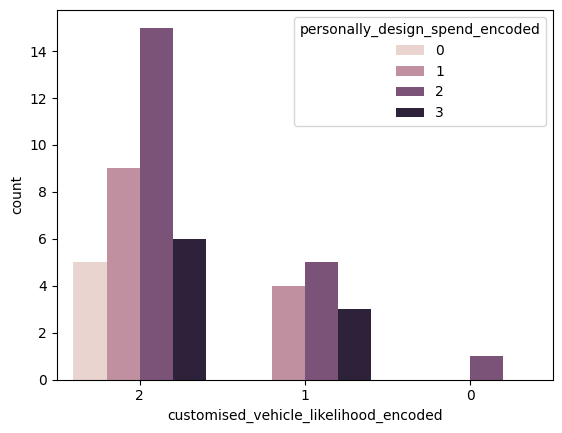

In [680]:
x = data['customised_vehicle_likelihood_encoded']
hue = 'personally_design_spend_encoded'
sns.countplot(x=x,hue=hue,data=data,order=x.value_counts().head(10).index)

<Axes: xlabel='customised_vehicle_likelihood_encoded', ylabel='count'>

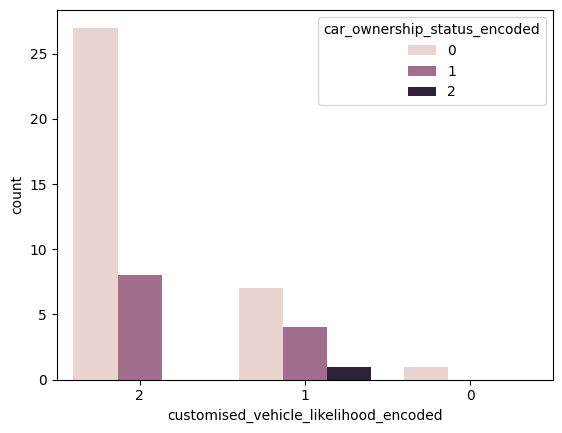

In [681]:
x = data['customised_vehicle_likelihood_encoded']
hue = 'car_ownership_status_encoded'
sns.countplot(x=x,hue=hue,data=data,order=x.value_counts().head(10).index)

In [683]:
data['customisation_spend_encoded'].unique()

array([1, 2, 3, 0])

In [682]:
data.groupby('customised_vehicle_likelihood_encoded')['personally_design_spend_encoded'].value_counts()

customised_vehicle_likelihood_encoded  personally_design_spend_encoded
0                                      2                                   1
1                                      2                                   5
                                       1                                   4
                                       3                                   3
2                                      2                                  15
                                       1                                   9
                                       3                                   6
                                       0                                   5
Name: count, dtype: int64

In [685]:
#membership to unlimited spending
test_dict = {'spend':['0', '0-500', '500-1000', 'over 1000']}
fuzzified_dict = {}
for key, value in test_dict.items():
  fuzzified_values = []
  for val in value:
    if val == '0':
      fuzzified_values.append(0)
    elif val == 'over 1000':
      fuzzified_values.append(1)
    else:
      lower_bound, upper_bound = val.split('-')
      lower_bound = int(lower_bound)
      upper_bound = int(upper_bound)
      fuzzified_value = (lower_bound + upper_bound) / 2000
      fuzzified_values.append(fuzzified_value)
  fuzzified_dict[key] = fuzzified_values

print(fuzzified_dict)


{'spend': [0, 0.25, 0.75, 1]}


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process



In [625]:
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process

# a_list = ['a', 'b', 'c']
# b_list = ['b', 'c', 'd']

# for a in a_list:
#   for b in b_list:
#     if b in a_list:
#       print('ji')

# print(fuzz.ratio(a_list, b_list))

ji
ji
ji
ji
ji
ji
67


In [626]:
# column_names = ['age_group', 
#                 'gender', 
#                 'car_ownership_status', 
#                 'maritial_status', 
#                 'customised_vehicle_likelihood', 
#                 'customisation_spend', 
#                 'personally_design_interest', 
#                 'personally_design_spend', 
#                 '3D_design_experience'
#                 ]
# fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
# plt.axis('off')
# for i, col in enumerate(column_names):
#   plt.subplot(5, 2, i+1)
#   sns.countplot(data, y=col+'_encoded', orient='h')
#   plt.title(col)
#   plt.xlim(0,50)
# plt.show()